# Running analysis on plasmid-borne data

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [3]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.viz
import mut.bayes
import pystan
constants = mut.thermo.load_constants()
colors = mut.viz.color_selector('pboc')
mut.viz.plotting_style()

In [72]:
# Load the data 
data = pd.read_csv('../../data/csv/Daber2011_data.csv')
idx = data.groupby(['IPTGuM']).ngroup()
data['idx'] = idx
# data = data[(data['idx'] != 14) & (data['idx'] != 13) & (data['idx']!=12)]

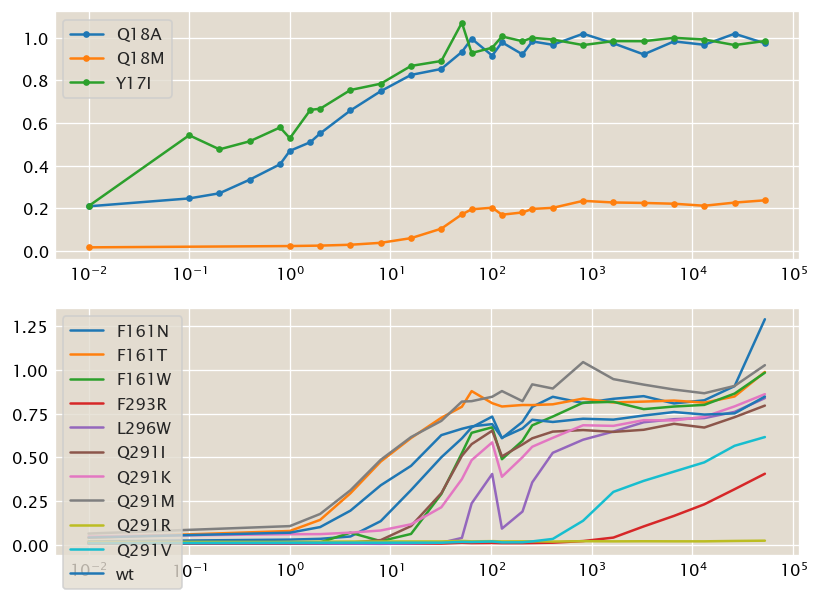

In [73]:
# Plot all of the data.
fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=120)
for a in ax:
    a.set_xscale('log')
for g, d in data.groupby(['class', 'mutant']):
    if g[0] == 'DNA': 
        ax[0].plot(d['IPTGuM'], d['fold_change'], '-o', label = g[1], ms=3)
    else:
        ax[1].plot(d['IPTGuM'], d['fold_change'], '-', label=g[1],   ms=3)
        
        
ax[0].legend()
ax[1].legend()

## R over $K_{DNA}$ $K_A$, $K_I$, and $\Delta \varepsilon$

As tal did in his analysis, we fit all four parameters to the wild-type strain, then use those as factors for determing the others given the mutants. Let's look at the wild-type

Text(0, 0.5, 'fold-change')

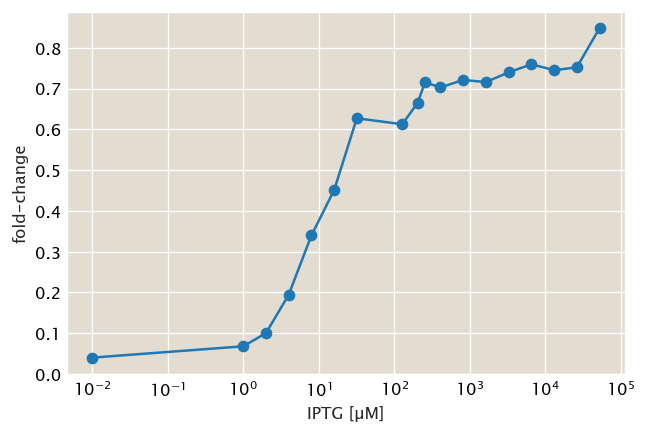

In [71]:
wt = data[data['mutant']=='wt']
fig, ax  = plt.subplots(1, 1, dpi=120)
ax.plot(wt['IPTGuM'], wt['fold_change'], '-o', label='wt')
ax.set_xscale('symlog', linthreshx=1E-3)
ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')

Now let's define a model to fit these four parameters. I'll skip the principled approach for now as it needs more attention. 

In [26]:
model_code = """
data { 
       int<lower=1> N; // number of data points
       vector<lower=0>[N] c; // IPTG concentration
       vector[N] fc; // Fold-change
       real ep_ai;
}
        
parameters {
     real<lower=0> r_kdna;
     real<lower=0> Ka;
     real<lower=0> Ki;
     real<lower=0> sigma;
}
    
model {
    vector[N] mu;
    vector[N] pact;
    // Define the priors
    r_kdna ~ lognormal(3, 3);
    Ka ~ lognormal(3, 3);
    Ki ~ lognormal(3, 3);
    sigma ~ normal(0, 1);
   
    for (i in 1:N) {
        pact[i] = 1 / (1 + exp(-ep_ai) * ((1 + c[i] / Ki) / (1 + c[i] / Ka))^2);
    
        mu[i] = 1 / (1 + pact[i] * r_kdna);
        }
    fc ~ normal(mu, sigma);    
}
    
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_610a528f51943dfa516c7ee77b73eb6b NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmp6ahni80m/stanfit4anon_model_610a528f51943dfa516c7ee77b73eb6b_2272317468171994403.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [27]:
# Define the data dictionary. 
data_dict = dict(N=len(wt), c=wt['IPTGuM'], fc=wt['fold_change'], ep_ai=-0.8)
samples = model.sampling(data_dict)

In [30]:
samples

Inference for Stan model: anon_model_610a528f51943dfa516c7ee77b73eb6b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r_kdna 317.04  132.39 3997.7  39.12   68.8 103.31 175.58 876.11    912    1.0
Ka      15.03    0.08   2.78  10.46  13.07  14.74   16.7  21.46   1338    1.0
Ki       1.35    0.02   0.63   0.35   0.91   1.27   1.72   2.77   1170    1.0
sigma    0.04  2.0e-4 7.3e-3   0.03   0.04   0.04   0.05   0.06   1350    1.0
lp__    53.48    0.05   1.59  49.61  52.67   53.8  54.66  55.48   1131    1.0

Samples were drawn using NUTS at Tue May  7 15:40:50 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [29]:
samples_df = samples.to_dataframe()

With the samples drawn, let's look at how well it describes the data 


In [37]:
c_range = np.logspace(-2, 5, 200)
cred_region = np.zeros((2, len(c_range)))
for i, c in enumerate(c_range):
    pact = mut.thermo.MWC(ka=samples_df['Ka'], ki=samples_df['Ki'], 
                         ep_ai=-0.8, effector_conc=c).pact()
    fc = (1 + samples_df['r_kdna'] * pact)**-1
    cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    
    
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.set_xscale('symlog', linthreshx=1E-3)
ax.plot(wt['IPTGuM'], wt['fold_change'], '.')

ax.fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.5)



KeyError: 'Ka'

With knowledge of the parameters, we will now fit R over k_DNA using only the means for each parameter

In [33]:
ka = samples_df['Ka'].mean()
ki = samples_df['Ki'].mean()
ep_ai = samples_df['ep_ai'].mean()
r_kdna = samples_df['r_kdna'].mean()

KeyError: 'ep_ai'

In [31]:
model_code = """
    data {
    int<lower=1> N; 
    vector<lower=0> [N] c;
    real<lower=0> Ka;
    real<lower=0> Ki;
    real ep_ai;
    vector[N] fc;
    }
    
    parameters {
    real<lower=0> r_kdna;
    real<lower=0> sigma;
    }
    
    model {
    vector[N] pact;
    vector[N] mu;
    r_kdna ~ lognormal(3, 3);
    sigma ~ normal(0, 1);
    for (i in 1:N) {
        pact[i] = 1 / (1 + exp(-ep_ai) * ((1 + c[i] / Ki) / (1 + c[i] / Ka))^2);
        mu[i] = (1 + pact[i] * r_kdna)^-1;
    }
    fc ~ normal(mu, sigma);
    } 
"""
operator_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8700a8c96796d0dbce52e34592237dc9 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpytpeplme/stanfit4anon_model_8700a8c96796d0dbce52e34592237dc9_3379632686071679629.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [34]:
dfs = []
for g, d in data[data['class']=='DNA'].groupby('mutant'):
    data_dict = dict(N=len(d), c=d['IPTGuM'], fc=d['fold_change'], Ka=constants['Ka'], Ki=constants['Ki'], ep_ai=constants['ep_AI'])
    samples = operator_model.sampling(data_dict)
    samples_df = samples.to_dataframe()
    samples_df['mutant'] = g
    dfs.append(samples_df)
op_dfs = pd.concat(dfs, axis=0)

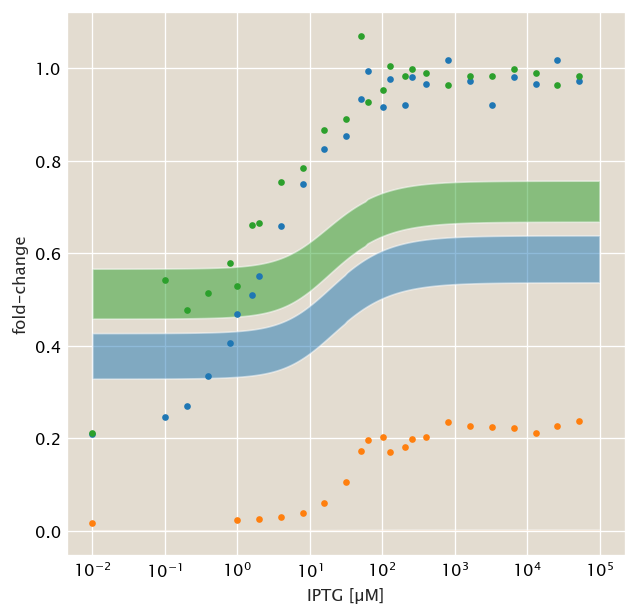

In [36]:
# Plot the mutants
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=120)
ax.set_xscale('symlog', linthreshx=1E-3)
ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')

pact = (1 + np.exp(-constants['ep_AI']) * ((1 + c_range / ki)/ (1 + c_range/ka))**2)**-1
# Plot the data. 
for g, d in data[data['class']=='DNA'].groupby('mutant'):
    ax.plot(d['IPTGuM'], d['fold_change'], '.', label=g)
    
    # Get the samples
    _samples = op_dfs[op_dfs['mutant']==g]
    
    # Compute the credible region
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        fc = (1 + pact[i] * _samples['r_kdna'])**-1
        cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
        
    ax.fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.5, label=g)

Now we can fit the inducer binding mutants. This one will be more difficult to display.

In [7]:
model_code = """
data {
    int<lower=1> N;
    vector<lower=0>[N] c;
    vector<lower=0>[N] fc;
    real r_kdna;
    real ep_ai;
}

parameters {
    real<lower=0> Ka;
    real<lower=0> Ki;
    real<lower=0> sigma;
}

model {
    vector[N] pact;
    vector[N] mu;
    Ka ~ lognormal(3, 3);
    Ki ~ lognormal(3, 3);
    sigma ~ normal(0, 1);
    
    for (i in 1:N) {
        pact[i] = 1 / (1 + exp(-ep_ai) * ((1 + c[i] / Ki) / (1 + c[i] / Ka))^2);
        mu[i] = 1 / (1 + pact[i] * r_kdna);
    }
    fc ~ normal(mu, sigma);
}
"""

ind_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8afcf9ea1407e50d91d40ef57667cd79 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmprxt8lg3z/stanfit4anon_model_8afcf9ea1407e50d91d40ef57667cd79_445875797902979483.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [21]:
dfs = []
for g, d in data[data['class']=='IND'].groupby('mutant'):
    data_dict = dict(N=len(d), c=d['IPTGuM'], fc=d['fold_change'], r_kdna=r_kdna, ep_ai=-0.8)
    samples = ind_model.sampling(data_dict)
    samples_df = samples.to_dataframe()
    samples_df['mutant'] = g
    dfs.append(samples_df)
ind_dfs = pd.concat(dfs, axis=0)

NameError: name 'r_kdna' is not defined

In [ ]:
samples

In [ ]:

# Plot the mutants
fig, ax = plt.subplots(10, 1, figsize=(8, 20), dpi=120, sharex=True, sharey=True)

for a in ax:
    a.set_xscale('symlog', linthreshx=1E-3)
    a.set_xlabel('IPTG [µM]')
    a.set_ylabel('fold-change')

# Plot the data. 
it = 0
a = 0
for g, d in data[data['class']=='IND'].groupby('mutant'): 
    

    
    # Get the samples
    _samples = ind_dfs[ind_dfs['mutant']==g]
    
    # Compute the credible region
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        pact = (1 + np.exp(-ep_ai) * ((1 + c/_samples['Ki'])/(1 + c/_samples['Ka']))**2)**-1
        fc = (1 + pact * r_kdna)**-1
        cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    

    ax[it].plot(d['IPTGuM'], d['fold_change'], '.', label=g)
    ax[it].fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.5, label='__nolegend__')
    it+=1


for a in ax:
    a.legend(loc='upper left')

## Inferring $R/K_\text{DNA}$ in conjunction with our $K_A$, $K_I$, and $\Delta\varepsilon_{AI}$

Let's just assume that we don't know the operator or repressor copy number, but we can treat that as the only unknown parameter *a priori*

In [16]:
model_code = """
data {
    int<lower=1> N;
    vector<lower=0>[N] c;
    vector[N] fc;
    real<lower=0> Ka;
    real<lower=0> Ki;
    real ep_ai;
}

parameters {
    real<lower=0> r_kdna;
    real<lower=0> sigma;
}

model {
    vector[N] pact;
    vector[N] mu;
    r_kdna ~ lognormal(3, 3);
    sigma ~ normal(0, 1);
    
    for (i in 1:N) {
        pact[i] = (1 + exp(-ep_ai) * ((1 + c[i] / Ki)/ (1 + c[i] / Ka))^2)^-1;
        mu[i] = (1 + pact[i] * r_kdna)^-1;
    }
    fc ~ normal(mu, sigma);
}
"""
rkdna_only_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_86927ca32d46b49ec32d4d7a0c15520c NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpo81t0r3e/stanfit4anon_model_86927ca32d46b49ec32d4d7a0c15520c_8548042004830230437.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [39]:
# Determine the value for the wild-type
data_dict = dict(N=len(wt), c=wt['IPTGuM'], fc=wt['fold_change'], Ka=float(constants['Ka']), Ki=float(constants['Ki']),
                ep_ai=float(constants['ep_AI']))
samples = rkdna_only_model.sampling(data_dict)
samples_df = samples.to_dataframe()
wt_rkdna = samples_df['r_kdna'].mean()


Text(0, 0.5, 'fold-change')

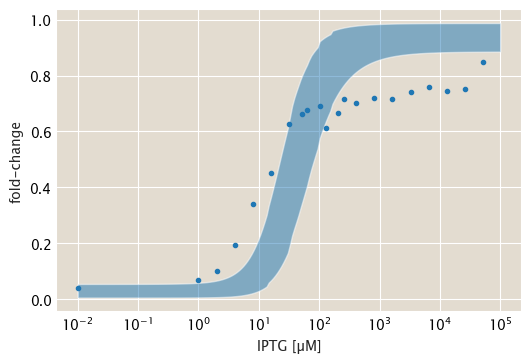

In [40]:
cred_region = np.zeros((2, len(c_range)))
for i, c in enumerate(c_range):
    pact = mut.thermo.MWC(ka=constants['Ka'], ki=constants['Ki'], 
                         ep_ai=constants['ep_AI'], effector_conc = c).pact()
    fc = (1 + samples_df['r_kdna'] * pact)**-1
    cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    
    
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.set_xscale('symlog', linthreshx=1E-3)
ax.plot(wt['IPTGuM'], wt['fold_change'], '.')

ax.fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.5)

ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')


In [41]:
samples

Inference for Stan model: anon_model_86927ca32d46b49ec32d4d7a0c15520c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r_kdna  50.64     0.5  25.32  14.36  32.04  46.77   64.1 111.12   2610    1.0
sigma    0.19  7.1e-4   0.03   0.14   0.17   0.19   0.21   0.27   2115    1.0
lp__    23.35    0.03   1.04  20.59  22.94  23.67  24.09  24.37   1424    1.0

Samples were drawn using NUTS at Tue May  7 15:46:37 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Now we can try it for the DNA binding mutants using our values. 


In [132]:
dfs = []
for g, d in data[data['class']=='DNA'].groupby('mutant'):
    data_dict = dict(N=len(d), c=d['IPTGuM'], fc=d['fold_change'], Ka=constants['Ka'], 
                    Ki=constants['Ki'], ep_ai=constants['ep_AI'])
    samples = operator_model.sampling(data_dict)
    samples_df = samples.to_dataframe()
    samples_df['mutant'] = g
    dfs.append(samples_df)
our_allo_op_dfs = pd.concat(dfs, axis=0)

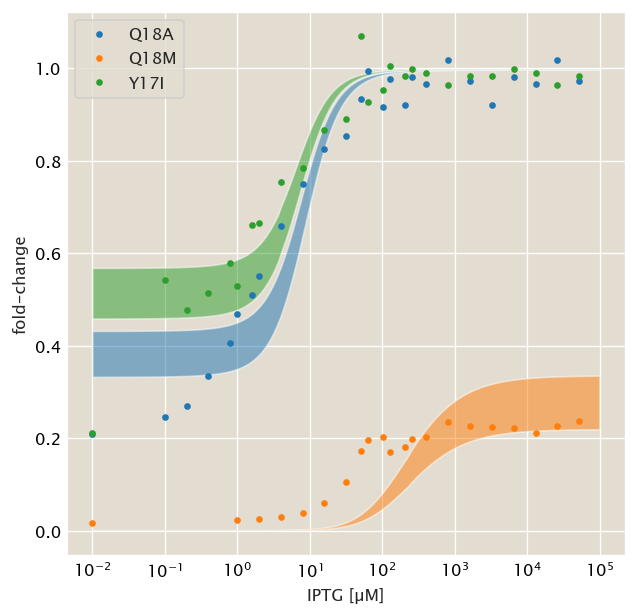

In [149]:
# Plot the mutants
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=120)
ax.set_xscale('symlog', linthreshx=1E-3)
ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')

pact = (1 + np.exp(-constants['ep_AI']) * ((1 + c_range / constants['Ki'])/ (1 + c_range/constants['Ka']))**2)**-1
# Plot the data. 
for g, d in data[data['class']=='DNA'].groupby('mutant'):
    ax.plot(d['IPTGuM'], d['fold_change'], '.', label=g)
    
    # Get the samples
    _samples = our_allo_op_dfs[our_allo_op_dfs['mutant']==g]
    
    # Compute the credible region
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        fc = (1 + pact[i] * _samples['r_kdna'])**-1
        cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
        
    ax.fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.5, label='__nolegend__')
    
ax.legend()

 Now we can assume only Ka and Ki change, while using our ep_ai and wt-derived r_kdna

In [150]:
dfs = []
stat_dfs = []
for g, d in data[data['class']=='IND'].groupby('mutant'):
    data_dict = dict(N=len(d), c=d['IPTGuM'], fc=d['fold_change'], r_kdna=wt_rkdna, ep_ai=constants['ep_AI'])
    samples = ind_model.sampling(data_dict)
    samples_df = samples.to_dataframe()
    stats = mut.stats.compute_statistics(samples_df, logprob_name='lp__', varnames=['Ka', 'Ki'])
    stats['mutatnt'] = g
    samples_df['mutant'] = g
    dfs.append(samples_df)
    stat_dfs.append(stats)
our_allo_ind_dfs = pd.concat(dfs, axis=0)
our_allo_stats = pd.concat(stat_dfs)

75.19822892081915 0.3546942315845636
11461.681963187835 0.009341776274220035
11.768673421326424 0.07558786562933306
3.006243044634416 7.654455111296572e-05
76.92036291399734 0.5259882684362871
352.7782196401802 0.008302338893252978
8541.397022820955 139.6325482549608
1614093.4747663783 238.85667002487915
353.44370678665786 2.9592521844555493
9729.857544822664 0.35703027601826365
40.18397748318221 0.39097400940334887
50.69643257582112 0.003258676618350891
68.99543273152311 0.631560641754348
246.3002839620279 0.013142436278096196
19.753982894954426 0.09151797780092834
23.804817951561873 0.00021418458005112906
50.63764627919962 3672.0635895623336
102895.14711262823 1609590283.78257
1890.6043757927214 23.48050913995608
59863.905421245945 6.141035156001502


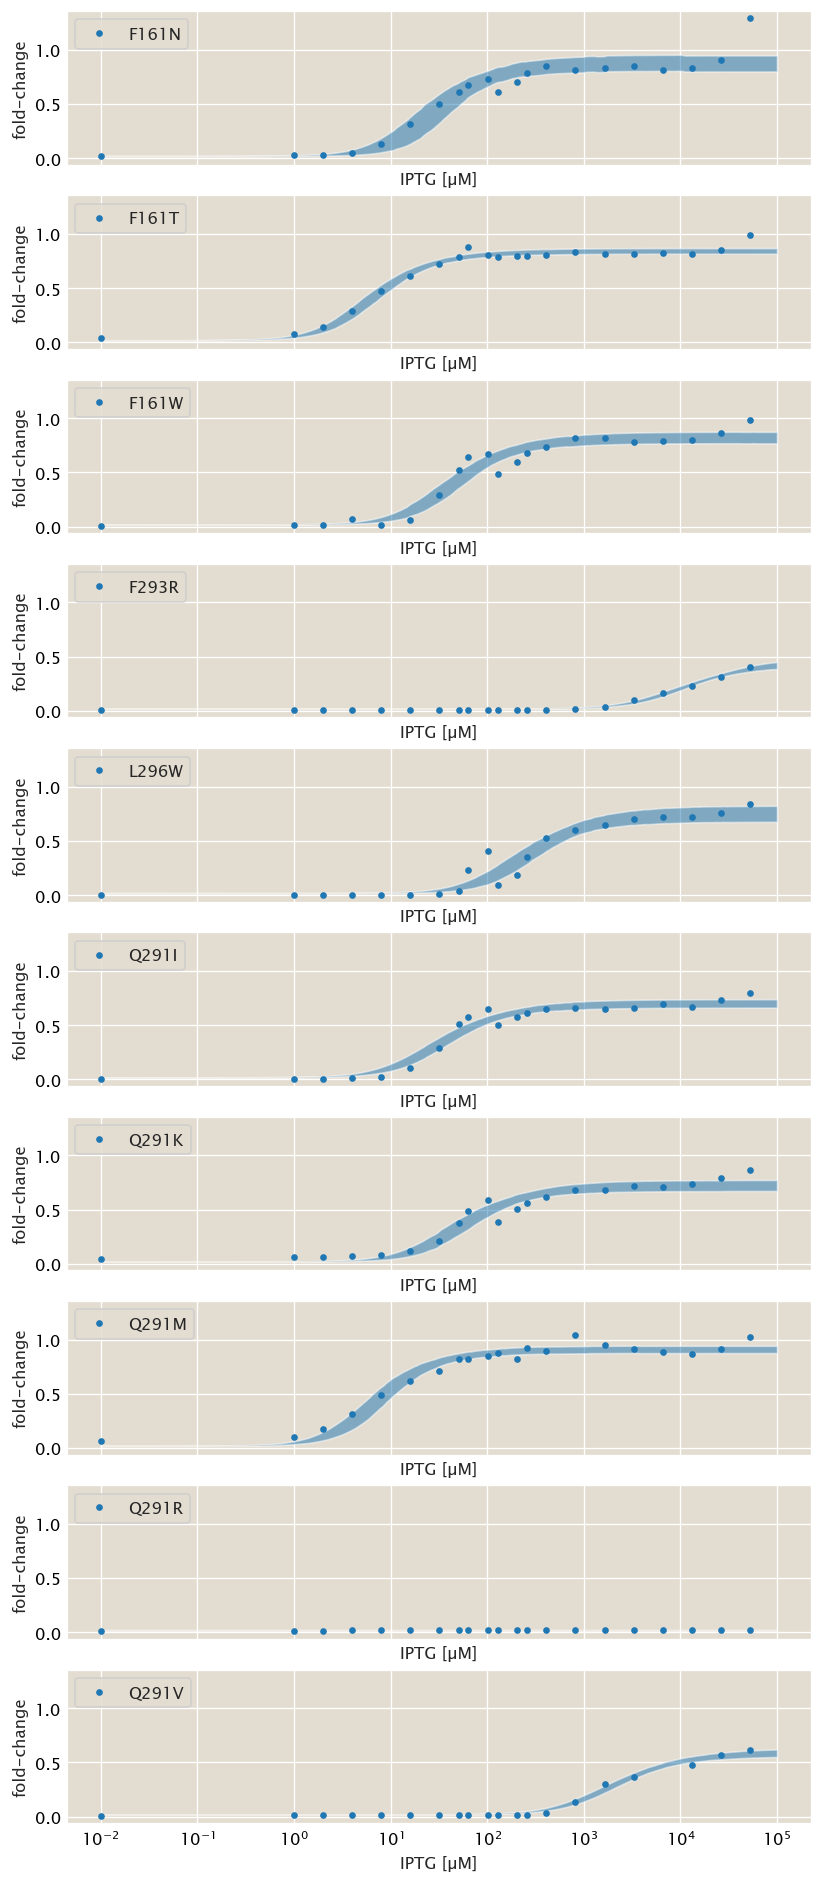

In [151]:
# Plot the mutants
fig, ax = plt.subplots(10, 1, figsize=(8, 20), dpi=120, sharex=True, sharey=True)

for a in ax:
    a.set_xscale('symlog', linthreshx=1E-3)
    a.set_xlabel('IPTG [µM]')
    a.set_ylabel('fold-change')

# Plot the data. 
it = 0
a = 0
for g, d in data[data['class']=='IND'].groupby('mutant'): 
     
    # Get the samples
    _samples = our_allo_ind_dfs[our_allo_ind_dfs['mutant']==g] 
    print(np.mean(_samples['Ka']), np.mean(_samples['Ki']))
    print(np.var(_samples['Ka']), np.var(_samples['Ki']))
    
    # Compute the credible region
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        pact = (1 + np.exp(-constants['ep_AI']) * ((1 + c/_samples['Ki'])/(1 + c/_samples['Ka']))**2)**-1
        fc = (1 + pact * wt_rkdna)**-1
        cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    

    ax[it].plot(d['IPTGuM'], d['fold_change'], '.', label=g)
    ax[it].fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.5, label='__nolegend__')
    it+=1
        
for a in ax:
    a.legend(loc='upper left')

## Assuming single site repression 

I think if we assume it's single site repression, we can figure out wat $R$ is assuming the O1 binding energy

In [152]:
model_code = """
data {
    int<lower=1> N;
    vector<lower=0>[N] c;
    vector[N] fc;
    real Ka;
    real Ki;
    real ep_AI;
    real Nns;
    real ep_R;
    }

parameters {
    real<lower=1> R;
    real<lower=0> sigma;
}

model {
    vector[N] pact;
    vector[N] mu;
    R ~ normal(0, 1000);
    
    for (i in 1:N) {
        pact[i] = (1 + exp(-ep_AI) * ((1 + c[i]/Ki)/(1 + c[i]/Ka))^2)^-1;
        mu[i] = (1 + pact[i] * (R / Nns) * exp(-ep_R))^-1;
    }
    fc ~ normal(mu, sigma);
}
"""
R_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0fc4edf7b86804aeb92514e477a30322 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmp93kd826s/stanfit4anon_model_0fc4edf7b86804aeb92514e477a30322_1875298042345950087.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [20]:
data_dict = dict(N=len(wt), c=wt['IPTGuM'], ep_AI=constants['ep_AI'],
                 Ka=constants['Ka'], Ki=constants['Ki'], Nns=4.6E6,
                 ep_R=constants['O1'], fc=wt['fold_change'])
R_samples = R_model.sampling(data_dict)
R_df = R_samples.to_dataframe()
R_stats = mut.stats.compute_statistics(R_df, varnames=['R', 'sigma'], logprob_name='lp__')

NameError: name 'R_model' is not defined

In [157]:
R_stats

,parameter,mean,median,mode,hpd_min,hpd_max
0,R,67.559882,62.305908,64.538785,13.193641,130.227931
1,sigma,0.191167,0.186520,0.179579,0.132131,0.252699


Text(0, 0.5, 'fold-change')

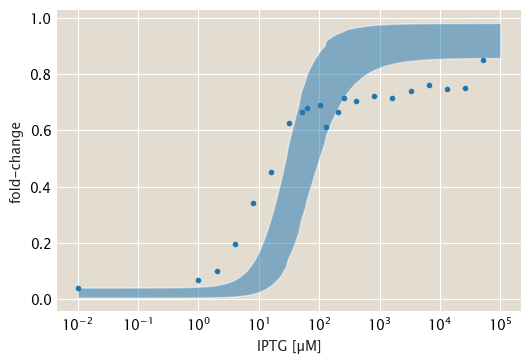

In [158]:
cred_region = np.zeros((2, len(c_range)))
for i, c in enumerate(c_range):
    pact = mut.thermo.MWC(ka=constants['Ka'], ki=constants['Ki'], 
                         ep_ai=constants['ep_AI'], effector_conc = c).pact()
    fc = (1 + (R_df['R'] / 4.6E6) * np.exp(-constants['O1']) * pact)**-1
    cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    
    
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.set_xscale('symlog', linthreshx=1E-3)
ax.plot(wt['IPTGuM'], wt['fold_change'], '.')

ax.fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.5)

ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')

In [159]:
ssr_rkdna = R_df['R'].mean() * np.exp(-constants['O1'])/constants['Nns']

Now we can estimate what the new binding energy is for each DNA domain mutant.  

In [161]:
model_code = """
data {
    int<lower=1> N;
    vector<lower=0>[N] c;
    vector[N] fc;
    real R;
    real Ka;
    real Ki;
    real ep_ai;
    real Nns;
}

parameters {
    real ep_r;
    real<lower=0> sigma;
}

model {
    vector[N] pact;
    vector[N] mu;
    ep_r ~ normal(-12, 12);
    sigma ~ normal(0, 1);
    
    for (i in 1:N) {
        pact[i] = (1 + exp(-ep_ai) * ((1 + c[i] / Ki)/(1 + c[i]/Ka))^2)^-1;
        mu[i]  = (1 + pact[i] * (R / Nns) * exp(-ep_r))^-1;
    }

    fc ~ normal(mu, sigma);
}
"""

epr_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d277bb96bb5aee1dee8f5680c842646 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpw_45d9ob/stanfit4anon_model_8d277bb96bb5aee1dee8f5680c842646_3257991799127962696.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [164]:
dfs = []
stat_dfs = []
for g, d in data[data['class']=='DNA'].groupby('mutant'):
    data_dict = dict(N=len(d), c=d['IPTGuM'], fc=d['fold_change'], Ka=constants['Ka'], 
                    Ki=constants['Ki'], ep_ai=constants['ep_AI'],  R=R_df['R'].mean(),
                    Nns=constants['Nns'])
    samples = epr_model.sampling(data_dict)
    samples_df = samples.to_dataframe()
    stats = mut.stats.compute_statistics(samples_df, varnames=['ep_r', 'sigma'], logprob_name='lp__')
    samples_df['mutant'] = g
    stats['mutant']=g
    stat_dfs.append(stats)
    dfs.append(samples_df)
epR_dfs = pd.concat(dfs, axis=0)
epR_stats = pd.concat(stat_dfs, axis=0)

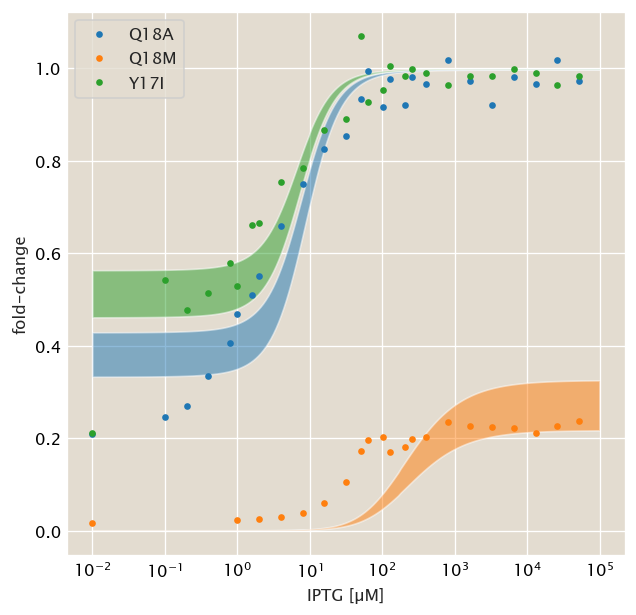

In [166]:
# Plot the mutants
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=120)
ax.set_xscale('symlog', linthreshx=1E-3)
ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')

pact = (1 + np.exp(-constants['ep_AI']) * ((1 + c_range / constants['Ki'])/ (1 + c_range/constants['Ka']))**2)**-1
# Plot the data. 
for g, d in data[data['class']=='DNA'].groupby('mutant'):
    ax.plot(d['IPTGuM'], d['fold_change'], '.', label=g)
    
    # Get the samples
    _samples = epR_dfs[epR_dfs['mutant']==g]
    
    # Compute the credible region
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        fc = (1 + pact[i] * (R_df['R'].mean() / constants['Nns']) * np.exp(-_samples['ep_r']))**-1
        cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
        
    ax.fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.5, label='__nolegend__')
    
ax.legend()

Using the estimated R, infer Ka Ki and epAI 

In [169]:
dfs = []
stat_dfs = []
for g, d in data[data['class']=='IND'].groupby('mutant'):
    data_dict = dict(N=len(d), c=d['IPTGuM'], fc=d['fold_change'], r_kdna=ssr_rkdna, ep_ai=constants['ep_AI'])
    samples = ind_model.sampling(data_dict)
    samples_df = samples.to_dataframe()
    stats = mut.stats.compute_statistics(samples_df, logprob_name='lp__', varnames=['Ka', 'Ki'])
    stats['mutatnt'] = g
    samples_df['mutant'] = g
    dfs.append(samples_df)
    stat_dfs.append(stats)
R_ind_dfs = pd.concat(dfs, axis=0)
R_ind_stats = pd.concat(stat_dfs)